# Module importieren

In [1]:
import mglearn
import csv
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sns

from pandas import DataFrame
from csv import reader
from sklearn import preprocessing, svm, metrics
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import  confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, make_scorer, precision_recall_curve
from sklearn.utils.fixes import signature
from IPython.display import display
from mlxtend.plotting import plot_confusion_matrix
from timeit import timeit

#Warnungen unterdrücken
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def draw_confusionmatrix(labels_test, pred):
    fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(labels_test, pred))
    ax.set(title="Konfusionsmatrix", ylabel='Tatsächliche Klasse', xlabel='Vorhergesagte Klasse')
    fig.set_size_inches(6, 6)
    plt.show()

def draw_roccurve(classifier, labels_test, features_test):
    fig = matplotlib.pyplot.gcf()
    test = classifier.predict_proba(features_test)[::,1]
    fpr, tpr, thresholds = metrics.roc_curve(labels_test, test)
    auc = metrics.roc_auc_score(labels_test, test)
    plt.plot(fpr,tpr,label="auc="+str(auc))
    plt.title("ROC Kurve")
    plt.legend(loc=4)
    fig.set_size_inches(6, 6)
    plt.show()
    print("AUC: " + str(auc))
    
def draw_curve(y_test, y_score):
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    
    step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
    plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Sensitivität')
    plt.ylabel('Relevanz')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall-Kurve')

def get_scores(labels, prediciton):
    recall = recall_score(labels, prediciton)
    precision = precision_score(labels, prediciton)
    print()
    print("Metriken ohne Kreuzvalidierung")
    print("Relevanz: " + str(round(precision*100,2)) + "%")
    print("Sensitivität: " + str(round(recall*100,2)) + "%")
    
def crossvalidation_all(classifier, labels, features, cv):
    scoring = {'accuracy' : make_scorer(accuracy_score), 
               'precision' : make_scorer(precision_score),
               'recall' : make_scorer(recall_score), 
               'f1_score' : make_scorer(f1_score)}
    results = cross_validate(estimator=classifier, 
                             X=features, 
                             y=labels, 
                             cv=cv, 
                             scoring=scoring, 
                             return_train_score=False)
    print()
    print("Metriken mit Kreuzvalidierung")
    print("Genauigkeit: " + str(round((np.mean(results['test_accuracy']) * 100),2)) + "%")
    print("Relevanz: " + str(round((np.mean(results['test_precision']) * 100),2)) + "%")
    print("Sensitivität: " + str(round((np.mean(results['test_recall']) * 100),2)) + "%")
    print("F1 Score: " + str(round((np.mean(results['test_f1_score']) * 100),2)) + "%")

def get_metriken(classifier, labels, features, cv):
    scoring = {'accuracy' : make_scorer(accuracy_score), 
               'precision' : make_scorer(precision_score),
               'recall' : make_scorer(recall_score), 
               'f1_score' : make_scorer(f1_score)}
    results = cross_validate(estimator=classifier, 
                             X=features, 
                             y=labels, 
                             cv=cv, 
                             scoring=scoring, 
                             return_train_score=False)
    output = {"accuracy":round((np.mean(results['test_accuracy']) * 100),2),"precision":round((np.mean(results['test_precision']) * 100),2),"recall":round((np.mean(results['test_recall']) * 100),2),"f1score":round((np.mean(results['test_f1_score']) * 100),2)}
    return(output)

def autolabel(rects):
    for rect in rects:
        height = int(rect.get_y()) + int(rect.get_height())
        ax.text(rect.get_x() + rect.get_width()/2., height - 10,
                '%d' % height,
                ha='center', va='bottom')

# Daten einlesen und erste Analysen

In [3]:
datei='adult.csv'
data=pd.read_csv(datei)
datareduziert = data[['age', 'workclass', 'education', 'gender', 'hours-per-week',
             'occupation', 'income']]
df= pd.DataFrame(datareduziert)
print("Folgende Schlüssel befinden sich im Datensatz:")
print(data.keys())
print()
print("Gesamte Anzahl der Datensätze: {}".format(data.shape[0]))

data.describe()

Folgende Schlüssel befinden sich im Datensatz:
Index(['age', 'workclass', 'fnlwgt', 'education', 'educational-num',
       'marital-status', 'occupation', 'relationship', 'race', 'gender',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

Gesamte Anzahl der Datensätze: 48842


,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


# Analyse der Daten

## Heatmap

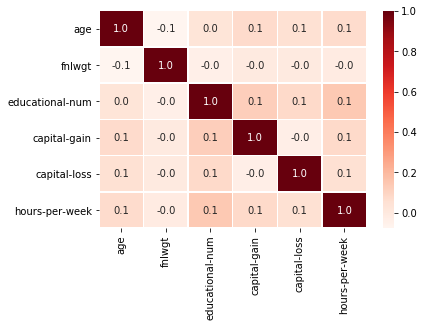

In [4]:
sns.heatmap(data.corr(),annot=True,fmt='.1f',linewidths=.5, cmap="Reds")  #We can use a simple seaborn method to draw the heatmaps


## Verteilung der Variablen
### Aufteilung der Geschlechter

Male      32650
Female    16192
Name: gender, dtype: int64


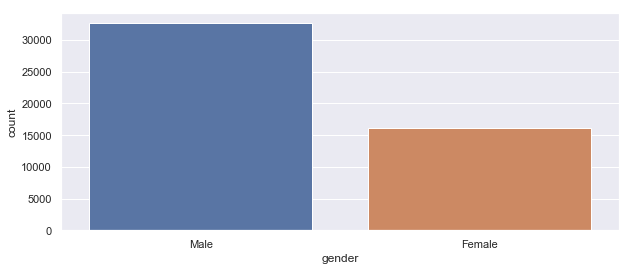

In [5]:
sns.set(style="darkgrid",rc={'figure.figsize':(10,4)})
#sns.load_dataset(data["gender"])
bar = sns.countplot(data=data, x="gender")
print(data.gender.value_counts())

### Einkommen nach Alter und Geschlecht

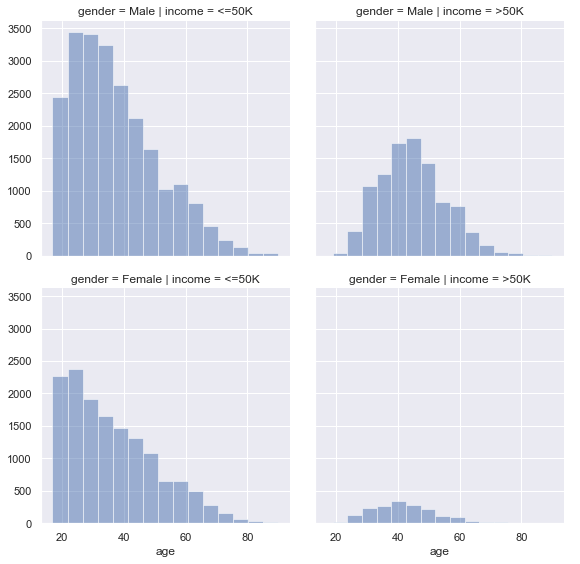

In [6]:
g = sns.FacetGrid(data, row='gender', col='income', height=4)
g.map(plt.hist, 'age', alpha=0.5, bins=15)
g.add_legend()
plt.show()

### Einkommen nach Berufsfeld

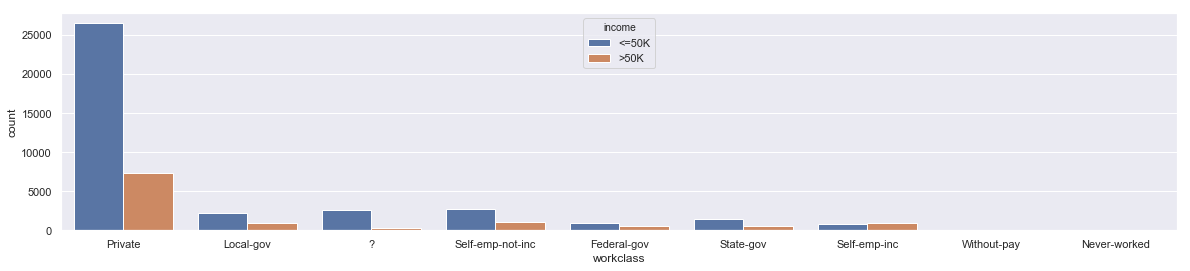

In [7]:
sns.set(style="darkgrid",rc={'figure.figsize':(20,4)})
bar = sns.countplot(data=data, x="workclass", hue="income")

In [8]:
df.head()

,age,workclass,education,gender,hours-per-week,occupation,income
0,25,Private,11th,Male,40,Machine-op-inspct,<=50K
1,38,Private,HS-grad,Male,50,Farming-fishing,<=50K
2,28,Local-gov,Assoc-acdm,Male,40,Protective-serv,>50K
3,44,Private,Some-college,Male,40,Machine-op-inspct,>50K
4,18,?,Some-college,Female,30,?,<=50K


age und hours-per-week sind kontinuierliche Merkmale

workclass, education, gender, occupation sind kategorische Merkmale (Kein Wertebereich, sondern festgelegte Liste von Werte) -> qualitative Eigenschaft

# One-Hot-Kodierung

### Spalten umwandeln

In [9]:
#print("Original features:\n", list(data.columns), "\n")
data_dummies = pd.get_dummies(data)
#print("Features after get_dummies:\n", list(data_dummies.columns))

### Neue Tabelle anzeigen

In [10]:
data_dummies.head()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,income_<=50K,income_>50K
0,25,226802,7,0,0,40,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1,38,89814,9,0,0,50,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,28,336951,12,0,0,40,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
3,44,160323,10,7688,0,40,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
4,18,103497,10,0,0,30,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0


### Neue Spalten umbenennen

In [11]:
data_dummies.rename(columns={'income_>50K': 'mehrals50K', 'income_<=50K': 'wenigerals50K'}, inplace=True)
#data_dummies.keys()

### Prüfung auf leere Zellen

In [12]:
if(data_dummies.isnull().values.any() == False):
    print("Keine Leeren Zellen im Datensatz vorhanden!")
else:
    print("Mindestens eine leere Zelle im Datensatz vorhanden!")

Keine Leeren Zellen im Datensatz vorhanden!


# Daten verarbeiten
### Variablen festlegen

In [13]:
#Remove labels
features = data_dummies.drop(['mehrals50K', 'wenigerals50K'], axis=1)
labels = data_dummies.mehrals50K
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.25, random_state=5)

#Ausgabe
print("Features")
print("Trainingsdaten: " + str(features_train.shape[0]))
print("Testdaten: " + str(features_test.shape[0]))
print()
print("Labels")
print("Trainingsdaten: " + str(labels_train.shape[0]))
print("Testdaten: " + str(labels_test.shape[0]))


Features
Trainingsdaten: 36631
Testdaten: 12211

Labels
Trainingsdaten: 36631
Testdaten: 12211


## Baseline erstellen

In [14]:
feature_list = list(features.columns)
#baseline_preds = features_test[:, feature_list.index('mehrals50K')]

# Random Forest

In [15]:
rf_clf = RandomForestClassifier(n_estimators=50)
rf_clf.fit(features_train, labels_train)
rf_predictions = rf_clf.predict(features_test)

## Genauigkeit überprüfen 

Genauigkeit mit Prüfung der Testdaten: 85.19%



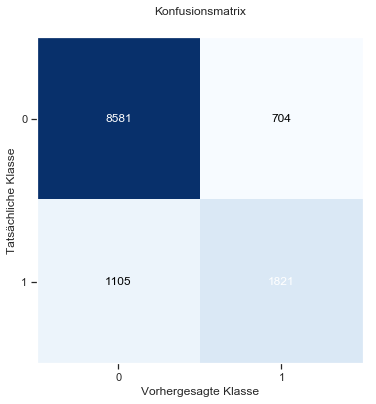

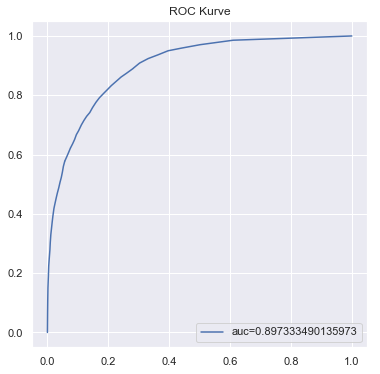

AUC: 0.897333490135973

Metriken ohne Kreuzvalidierung
Relevanz: 72.12%
Sensitivität: 62.24%

Metriken mit Kreuzvalidierung
Genauigkeit: 85.19%
Relevanz: 72.57%
Sensitivität: 61.26%
F1 Score: 66.43%


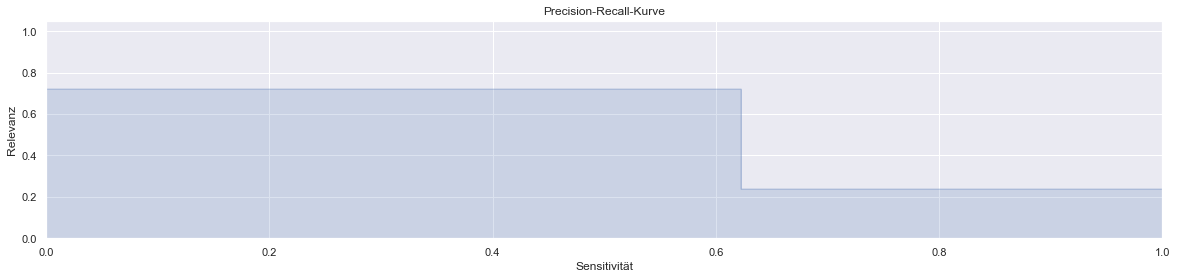

In [16]:
print ("Genauigkeit mit Prüfung der Testdaten:", str(round(accuracy_score(labels_test, rf_predictions)*100,2)) + "%")
print()

draw_confusionmatrix(labels_test, rf_predictions)
draw_roccurve(rf_clf, labels_test, features_test)
draw_curve(labels_test, rf_predictions)
get_scores(labels_test, rf_predictions)
crossvalidation_all(rf_clf, labels, features, 5)

[Quelle](http://dataaspirant.com/2017/06/26/random-forest-classifier-python-scikit-learn/)

# Decision Tree

In [17]:
tree_clf = DecisionTreeClassifier(max_depth=10, min_samples_leaf=5)
tree_clf.fit(features_train, labels_train)
tree_prediction = tree_clf.predict(features_test)

## Genauigkeit überprüfen

Genauigkeit mit Prüfung der Testdaten: 85.65%



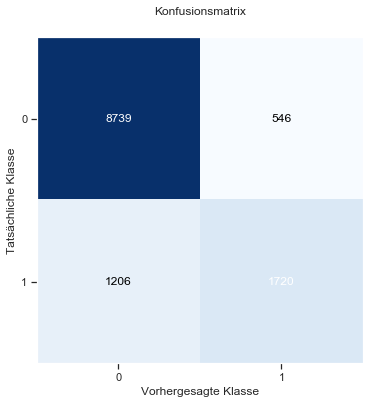

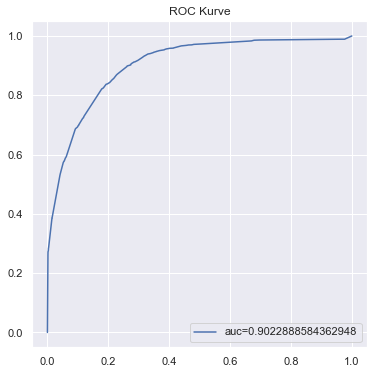

AUC: 0.9022888584362948

Metriken ohne Kreuzvalidierung
Relevanz: 75.9%
Sensitivität: 58.78%

Metriken mit Kreuzvalidierung
Genauigkeit: 85.92%
Relevanz: 76.87%
Sensitivität: 58.9%
F1 Score: 66.69%


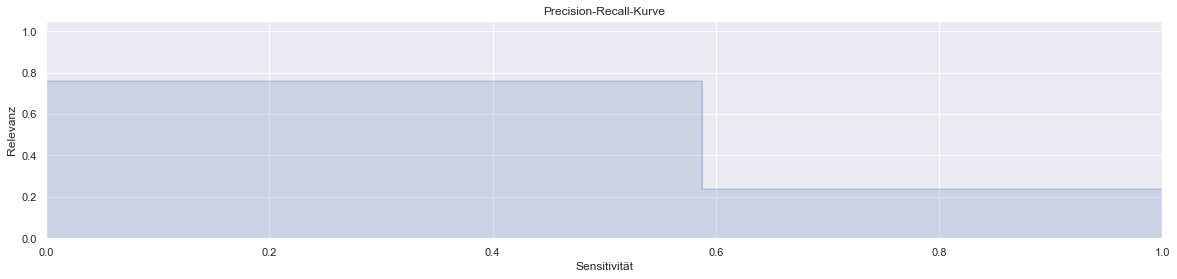

In [18]:
print ("Genauigkeit mit Prüfung der Testdaten:", str(round(accuracy_score(labels_test, tree_prediction)*100,2)) + "%")
print()

draw_confusionmatrix(labels_test, tree_prediction)
draw_roccurve(tree_clf, labels_test, features_test)
draw_curve(labels_test, tree_prediction)
get_scores(labels_test, tree_prediction)
crossvalidation_all(tree_clf, labels, features, 5)

[Quelle](http://dataaspirant.com/2017/02/01/decision-tree-algorithm-python-with-scikit-learn/)

# Gradient Boosting Classifier

In [19]:
gb_clf = GradientBoostingClassifier(n_estimators=1000, learning_rate=1, max_features=2, max_depth = 2)
gb_clf.fit(features_train, labels_train)
gb_prediction = gb_clf.predict(features_test)

## Genauigkeit überprüfen

Genauigkeit mit Prüfung der Testdaten: 86.26%



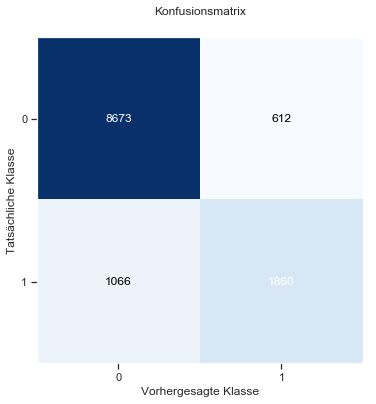

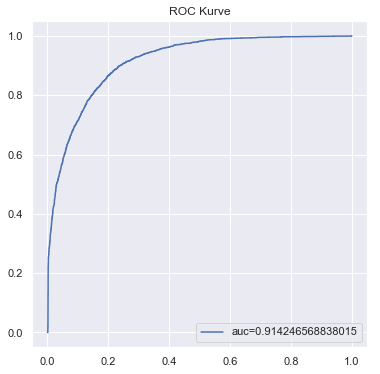

AUC: 0.914246568838015

Metriken ohne Kreuzvalidierung
Relevanz: 75.24%
Sensitivität: 63.57%

Metriken mit Kreuzvalidierung
Genauigkeit: 86.45%
Relevanz: 75.71%
Sensitivität: 63.89%
F1 Score: 69.3%


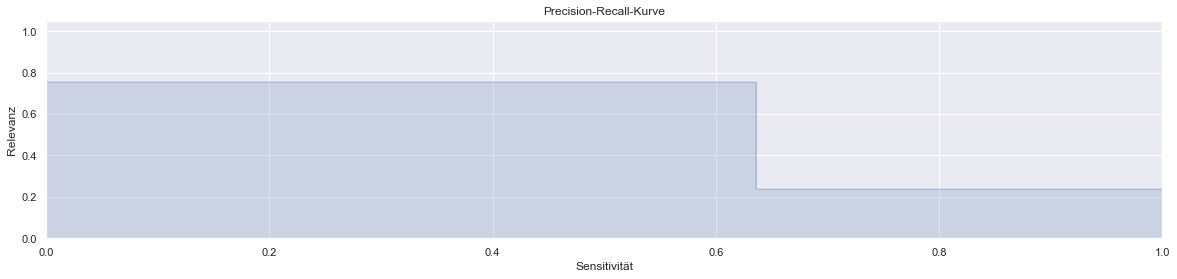

In [20]:
print ("Genauigkeit mit Prüfung der Testdaten:", str(round(accuracy_score(labels_test, gb_prediction)*100,2)) + "%")
print()

draw_confusionmatrix(labels_test, gb_prediction)
draw_roccurve(gb_clf, labels_test, features_test)
draw_curve(labels_test, gb_prediction)
get_scores(labels_test, gb_prediction)
crossvalidation_all(gb_clf, labels, features, 5)

# Evaluation der Modelle

## Runtime vergleichen

In [34]:
def time_RandomForest():
    rf_clf = RandomForestClassifier()
    rf_clf.fit(features_train, labels_train)
    rf_predictions = rf_clf.predict(features_test)
    
def time_DecisionTree():
    tree_clf = DecisionTreeClassifier(max_depth=10, min_samples_leaf=5)
    tree_clf.fit(features_train, labels_train)
    tree_prediction = tree_clf.predict(features_test)

def time_GradientBoost():
    gb_clf = GradientBoostingClassifier(n_estimators=1000, learning_rate=1, max_features=2, max_depth = 2)
    gb_clf.fit(features_train, labels_train)
    gb_prediction = gb_clf.predict(features_test)
    
def get_time(clf, numberOfRuns, name):
    time = timeit(clf, number=numberOfRuns)
    print("Runtime of the " + name + " Classifier: " + str(round((time / numberOfRuns),2)) + "s")
    
numberOfRuns = 10

get_time(time_RandomForest, numberOfRuns, "Random Forest")
get_time(time_DecisionTree, numberOfRuns, "Decision Tree")
get_time(time_GradientBoost, numberOfRuns, "Gradient Boost")



Runtime of the Random Forest Classifier: 0.76s
Runtime of the Decision Tree Classifier: 0.33s
Runtime of the Gradient Boost Classifier: 6.14s


In [35]:
#Modelle vergleichen
rf_values = get_metriken(rf_clf, labels, features, 5)
tree_values = get_metriken(tree_clf, labels, features, 5)
gb_values = get_metriken(gb_clf, labels, features, 5)

## Accuracy vergleichen

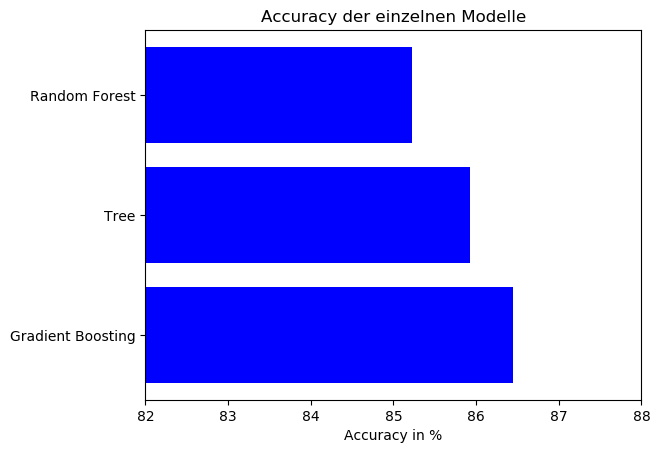

In [36]:
# Genauigkeit vergleichen
plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
modelle = ('Random Forest', 'Tree', 'Gradient Boosting')
y_pos = np.arange(len(modelle))
genauigkeit = (rf_values['accuracy'], tree_values['accuracy'], gb_values['accuracy'])

ax.barh(y_pos, genauigkeit, align='center', color='blue')
ax.set_yticks(y_pos)
ax.set_yticklabels(modelle)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Accuracy in %')
ax.set_title('Accuracy der einzelnen Modelle')
ax.set_xlim([82, 88])


plt.show()

## Precision vergleichen

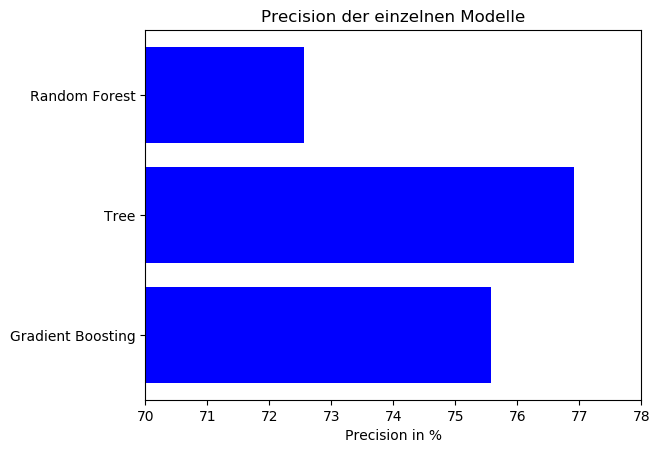

In [37]:
# Relevanz vergleichen
plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
modelle = ('Random Forest', 'Tree', 'Gradient Boosting')
y_pos = np.arange(len(modelle))
precision = (rf_values['precision'], tree_values['precision'], gb_values['precision'])

ax.barh(y_pos, precision, align='center', color='blue')
ax.set_yticks(y_pos)
ax.set_yticklabels(modelle)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Precision in %')
ax.set_title('Precision der einzelnen Modelle')
ax.set_xlim([70, 78])


plt.show()

## Recall vergleichen

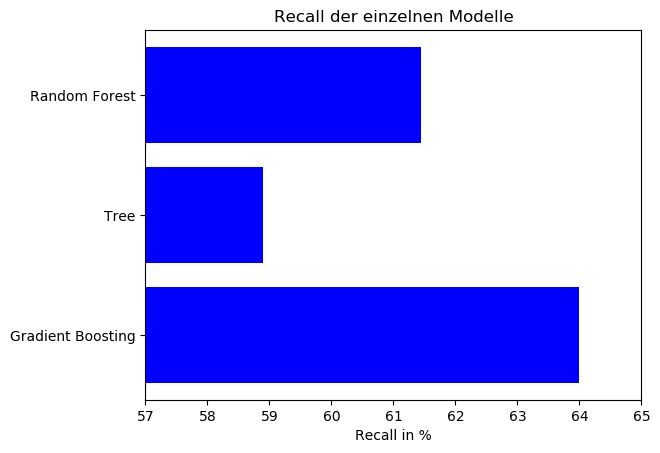

In [38]:
# Sensitivität vergleichen
plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
modelle = ('Random Forest', 'Tree', 'Gradient Boosting')
y_pos = np.arange(len(modelle))
recall = (rf_values['recall'], tree_values['recall'], gb_values['recall'])

ax.barh(y_pos, recall, align='center', color='blue')
ax.set_yticks(y_pos)
ax.set_yticklabels(modelle)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Recall in %')
ax.set_title('Recall der einzelnen Modelle')
ax.set_xlim([57, 65])


plt.show()

## F1-Score vergleichen

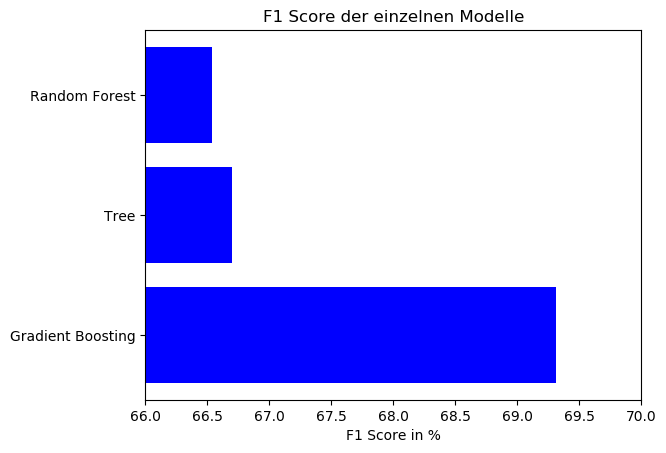

In [39]:
# Sensitivität vergleichen
plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
modelle = ('Random Forest', 'Tree', 'Gradient Boosting')
y_pos = np.arange(len(modelle))
f1score = (rf_values['f1score'], tree_values['f1score'], gb_values['f1score'])

ax.barh(y_pos, f1score, align='center', color='blue')
ax.set_yticks(y_pos)
ax.set_yticklabels(modelle)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('F1 Score in %')
ax.set_title('F1 Score der einzelnen Modelle')
ax.set_xlim([66, 70])


plt.show()

## Zusammenfassung der Evaluation

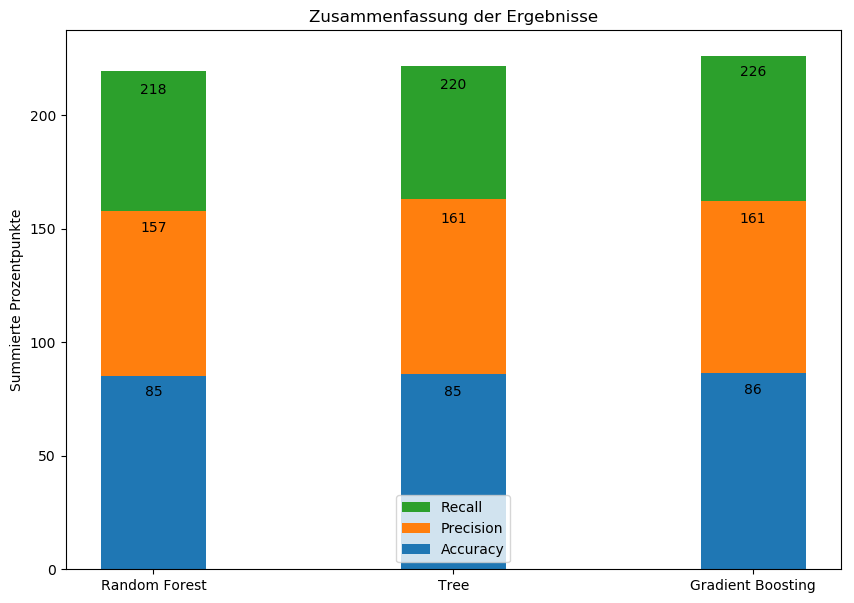

In [40]:
fig, ax = plt.subplots(figsize=(10, 7))
modelle = ('Random Forest', 'Tree', 'Gradient Boosting')
x_pos = np.arange(len(modelle))

ind = np.arange(3)
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = ax.bar(ind, genauigkeit, width)
p2 = ax.bar(ind, precision, width, bottom=genauigkeit)
p3 = ax.bar(ind, recall, width, bottom=np.array(genauigkeit)+np.array(precision))

ax.set_ylabel('Summierte Prozentpunkte')
ax.set_title('Zusammenfassung der Ergebnisse')
ax.set_xticks(x_pos)
ax.set_xticklabels(modelle)
ax.legend((p3[0], p2[0], p1[0]), ('Recall', 'Precision', 'Accuracy'), loc=8)

autolabel(p3)
autolabel(p2)
autolabel(p1)

plt.show()